In [12]:
# simulation of solving a non-linear inverse problem based on machine learning
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
from matplotlib import pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers.merge import add
from keras.models import Model
from keras import backend as K

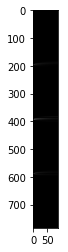

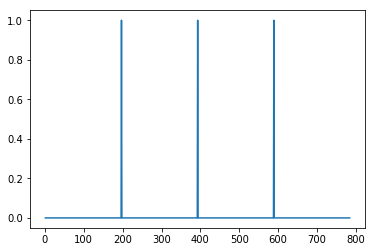

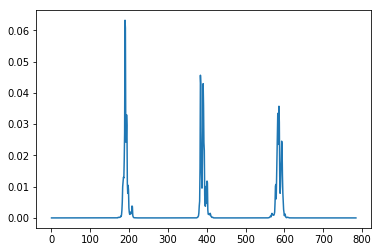

In [8]:
# generate a linear conplex transformation matrix H_sys; 
# the forward model is defined as Y = |H_sys X| 
# where H_sys is a coplex matrix
lamb = 405e-6
beta = 2*np.pi/lamb*1.5
#beta=6
c0 = 0.3
n_f = 28*28
z = range(0,900,10)
dz=0.001
n_z = len(z)
T = np.ones((n_f,n_f),dtype = float)-1
dA0=np.eye(n_f) *(1-2*c0)  
gamma = 0.2
c = c0*np.ones((n_f),dtype=float)+(np.random.rand(n_f)-.5)/.5*gamma
c2=np.subtract(2*c0,np.ones(n_f,dtype=float)*c)
dA1_temp=np.append(1j*np.diag(c*np.exp(1j*beta*dz)), np.zeros((n_f,1),dtype=float), axis = 1) 

dA1=dA1_temp[:,1:]
dA2_temp=np.append(np.zeros((n_f,1),dtype=float),1j*np.diag(c2*np.exp(1j*beta*dz)), axis = 1) 

dA2=dA2_temp[:,:-1]
dA = dA1 +dA2+dA0;
E_in = np.zeros([n_f,n_z],dtype = float)+0j;
#E_field[np.uint(n_f - (n_f-1)/2), 0] = 1;
E_in[np.uint(n_f - n_f/4), 0] = 1;
E_in[np.uint(n_f - n_f/2), 0] = 1;
E_in[np.uint(n_f - n_f/4*3), 0] = 1;
#E_in[np.uint(n_f - n_f), 0] = 1;
E_field = E_in
H_sys = dA
for ii in range(0, n_z-1):
    E_field[:,ii+1] = np.dot(E_field[:,ii],dA)
    H_sys = np.dot(H_sys,dA)

E_prop = np.absolute(E_field)
E_out = np.absolute(np.dot(E_in[:,0],H_sys))



plt.figure(1)
plt.imshow(E_prop, cmap='gray')
plt.figure(2)
plt.plot(range(1,n_f+1), np.absolute(E_in[:,0]))
plt.figure(3)
plt.plot(range(1,n_f+1), E_out)
plt.show()

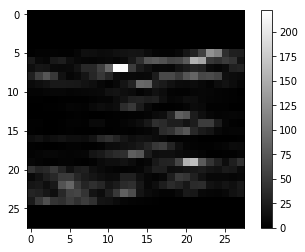

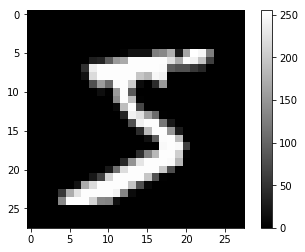

In [13]:
# prepare the data to NN


batch_size = 3
epochs = 20
# input image dimensions
img_rows, img_cols = 28, 28

# extract hand writting images as ground truth y_ train and y_test
(y_train, y_train0), (y_test, y_test0) = mnist.load_data()

# forward the input y_train y_test to spackle x_train, x_test  
y_train_vec = y_train.reshape(y_train.shape[0],img_rows*img_cols)
x_train = np.absolute(np.dot(y_train_vec,H_sys).reshape(y_train.shape[0],img_rows, img_cols,1))
y_test_vec = y_test.reshape(y_test.shape[0],img_rows*img_cols)
x_test = np.absolute(np.dot(y_test_vec,H_sys).reshape(y_test.shape[0],img_rows, img_cols,1))


# reshape to proper format 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],x_train.shape[2],1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1],y_train.shape[2],1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1],x_test.shape[2],1)
y_test  = y_test.reshape(y_test.shape[0], y_test.shape[1],y_test.shape[2],1)

# check input and labels of NN
plt.figure(4)
plt.imshow(x_train[0,:,:,0],cmap='gray')
plt.colorbar()
plt.figure(5)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.colorbar()
plt.show()


In [14]:
# define Batchormalizatin -> relu and convolutional blocks
ROW_AXIS = 1
COL_AXIS = 2
CHANNEL_AXIS = 3
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=1)(input)
    return Activation("relu")(norm)
def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f
def _bn_relu_convtrans(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f
def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])
def _shortcuttrans(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round( residual_shape[ROW_AXIS]/input_shape[ROW_AXIS] ))
    stride_height = int(round(residual_shape[COL_AXIS]/input_shape[COL_AXIS] ))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2DTranspose(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


input_nn = Input(shape=(img_rows,img_rows,1))


#down sampling residual layer

conv1 = _bn_relu_conv(filters=16, kernel_size=(3, 3), strides=(2, 2))(input_nn)
conv2 = _bn_relu_conv(filters=16, kernel_size=(3, 3), strides=(1, 1))(conv1)
SC1 = _shortcut(input_nn,conv2)
conv3 = _bn_relu_conv(filters=32, kernel_size=(3, 3), strides=(2, 2))(SC1)
conv4 = _bn_relu_conv(filters=32, kernel_size=(3, 3), strides=(1, 1))(conv3)
SC2 = _shortcut(SC1,conv4)


#down sampling residual layer
tconv4 = _bn_relu_convtrans(filters=64, kernel_size=(3, 3), strides=(2, 2))(SC2)
tconv3 = _bn_relu_convtrans(filters=64, kernel_size=(3, 3), strides=(1, 1))(tconv4)
SC3 = _shortcuttrans(SC2,tconv3)

#up sampling residual layer

tconv2 = _bn_relu_convtrans(filters=32, kernel_size=(3, 3), strides=(2, 2))(SC3)
tconv1 = _bn_relu_convtrans(filters=32, kernel_size=(3, 3), strides=(1, 1))(tconv2)
SC4 = _shortcuttrans(SC3,tconv1)
#up sampling residual layer
conv5 = _bn_relu_conv(filters=16, kernel_size=(3, 3), strides=(1, 1))(SC4)
conv6 = _bn_relu_conv(filters=16, kernel_size=(3, 3), strides=(1, 1))(conv5)
SC5 = _shortcut(SC4,conv6)

# standard residual blocks to output
conv7 = _bn_relu_conv(filters=1, kernel_size=(3, 3), strides=(1, 1))(SC5)
conv8 = _bn_relu_conv(filters=1, kernel_size=(3, 3), strides=(1, 1))(conv7)
SC6 = _shortcut(SC5,conv8)


model = Model(inputs=input_nn, outputs=SC6)
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='mean_absolute_error',
              optimizer=opt,
              metrics=['mae'])
model.fit(x_train[:1000,:,:,:], y_train[:1000,:,:,:],
             batch_size=3,
             epochs=20,
             validation_data=(x_test[:100:,:,:], y_test[:100:,:,:]),
             shuffle=1)
scores = model.evaluate(x_test[:100,:,:,:], y_test[:100,:,:,:], verbose=1)

Train on 1000 samples, validate on 100 samples
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 30.5742 - mean_absolute_error: 30.4983 - val_loss: 26.8746 - val_mean_absolute_error: 26.7923
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 22.9295 - mean_absolute_error: 22.8417 - val_loss: 22.0725 - val_mean_absolute_error: 21.9797
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 19.5982 - mean_absolute_error: 19.5013 - val_loss: 20.5322 - val_mean_absolute_error: 20.4313
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 17.5318 - mean_absolute_error: 17.4274 - val_loss: 17.8476 - val_mean_absolute_error: 17.7396
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 16.1275 - mean_absolute_error: 16.0163 - val_loss: 17.3372 - val_mean_absolute_error: 17.2231
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 15.0885 - mean_absolute_err

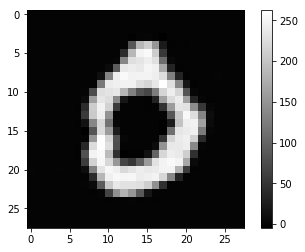

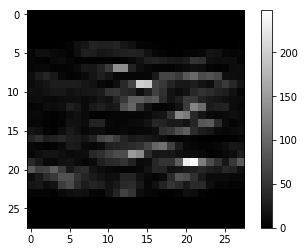

In [16]:
# show the power of our model on a speckle in test set
y0 = model.predict( x_test[:5,:,:,:], batch_size=None, verbose=0, steps=None)
plt.figure(6)
plt.imshow(y0[3,:,:,0],cmap='gray')
plt.colorbar()

plt.figure(7)
plt.imshow(x_test[3,:,:,0],cmap='gray')
plt.colorbar()
plt.show()